In [1]:
#import python packages
import keras
from keras.layers import Dense, Dropout, Lambda, Activation, Flatten, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
import pickle
from keras.applications import VGG16
import os
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.applications import MobileNetV2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Lambda, Activation, Flatten, Input

In [2]:
#function to normalize bounding boxes
def normalizeBoxes(bbox, w, h):
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return x_center, y_center, width, height

def reverse(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]

In [3]:
#function to get labels and bounding boxes
def getLabel(name):
    data = ['Block crack', 'D00', 'D10', 'D20', 'D40', 'Repair']
    label = -1
    for i in range(len(data)):
        if data[i] == name:
            label = i
            break
    return label

def getBoxes():
    box = []
    for i in range(0,12):
        box.append(0)
    return box

In [4]:
#load damage road dataset
labels = ['D00', 'D10', 'D20', 'D40', 'Repair']
if os.path.exists("model/X1.npy"):#if images already process then load it 
    data = np.load('model/X1.npy')
    labels = np.load('model/Y1.npy')
    bboxes = np.load('model/Z1.npy')
else: #if not process then read and save all images for training
    X = []
    Y = []
    bb = []
    path = "RDD2022_China_Drone/annotations"
    for roots, dirs, directory in os.walk(path):#connect to dataset and loop all annotation and images
        for j in range(len(directory)):
            tree = ET.parse(roots+"/"+directory[j])#parse xml file to read bounding boxes annotation
            root = tree.getroot()
            img_name = root.find('filename').text
            arr = img_name.split("_")
            img = cv2.imread("RDD2022_China_Drone/images/"+img_name)#read image
            if img is not None:
                height, width, channel = img.shape
                boxes = getBoxes()
                index = 0
                for item in root.findall('object'): #get boxes
                    name = item.find('name').text
                    xmin = float(item.find('bndbox/xmin').text)
                    ymin = float(item.find('bndbox/ymin').text)
                    xmax = float(item.find('bndbox/xmax').text)
                    ymax = float(item.find('bndbox/ymax').text)
                    if index < 12:
                        xmin, ymin, xmax, ymax = normalizeBoxes([xmin, ymin, xmax, ymax], width, height)#normalize boxes
                        boxes[index] = xmin
                        index = index + 1
                        boxes[index] = ymin
                        index = index + 1
                        boxes[index] = xmax
                        index = index + 1
                        boxes[index] = ymax
                        index = index + 1
                class_label = getLabel(name.strip())
                X.append(img) #save image and label and boxes as array
                Y.append(class_label)
                bb.append(boxes)
                print(img_name+" "+arr[0]+" "+str(boxes)+" "+str(class_label))

    X = np.asarray(X)#convert array to numpy format
    Y = np.asarray(Y)
    bb = np.asarray(bb)
    np.save('model/X.txt',X)#save all processed images
    np.save('model/Y.txt',Y)                    
    np.save('model/bb.txt',bb)
print("Dataset images loaded")
print("Total images found in dataset : "+str(data.shape[0]))
print("Labels found in dataset : "+str())

Dataset images loaded
Total images found in dataset : 200
Labels found in dataset : 


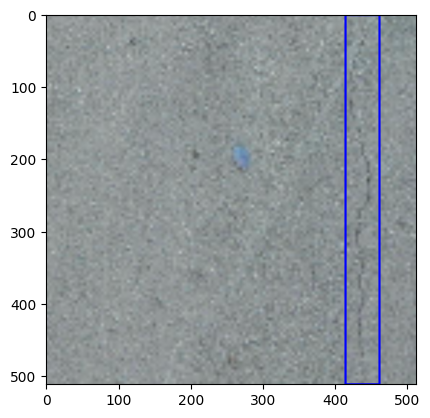

In [5]:
#display sample process image
import cv2
import matplotlib.pyplot as plt
sample_img = data[55]
sample_img = cv2.resize(sample_img, (512, 512))
box = bboxes[55]
xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
xmin, ymin, xmax, ymax = reverse([xmin, ymin, xmax, ymax], 512, 512)
cv2.rectangle(sample_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 2)
plt.imshow(sample_img)
plt.show()

In [6]:
#now normalized and shuffle images and then split into train and test
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
bboxes = bboxes[indices]
labels = to_categorical(labels)

split = train_test_split(data, labels, bboxes, test_size=0.20, random_state=42)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
print("80% dataset for training : "+str(trainImages.shape[0]))
print("20% dataset for training : "+str(testImages.shape[0]))

80% dataset for training : 160
20% dataset for training : 40


In [7]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [8]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    classes = ['D00', 'D10', 'D20', 'D40', 'Repair']
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = classes, yticklabels = classes, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(classes)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

2/2 [==============================] - 1s 56ms/step

YoloV5 Accuracy  : 62.5
YoloV5 Precision   : 82.55555555555556
YoloV5 Recall      : 60.55555555555555
YoloV5 FMeasure    : 62.46464646464646


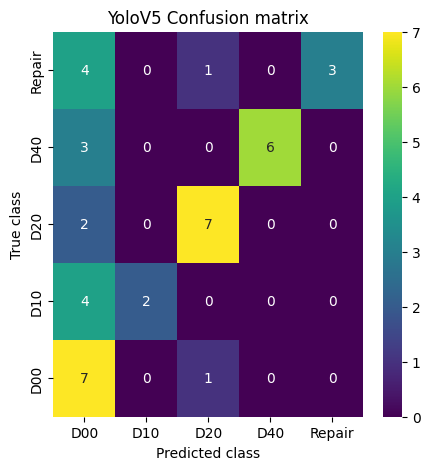

In [9]:
#now load yoloV5 model
input_img = Input(shape=(128, 128, 3))
#create YoloV5 layers with 32, 64 and 512 neurons or data filteration size
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(input_img)
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
#define output layer with 4 bounding box coordinate and 1 weapan class
x = Dense(512, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x_bb = Dense(12, name='bb')(x)
x_class = Dense(labels.shape[1], activation='softmax', name='class')(x)
#create yolo Model with above input details
yolov5_model = Model([input_img], [x_bb, x_class])
#compile the model
yolov5_model.compile(Adam(learning_rate=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'])
if os.path.exists("model/v5.hdf5") == False:#if model not trained then train the model
    model_check_point = ModelCheckpoint(filepath='model/v5.hdf5', verbose = 1, save_best_only = True)
    hist = yolov5_model.fit(data, [labels, bboxes], batch_size=32, epochs=20, validation_split=0.2, callbacks=[model_check_point])
    f = open('model/v5_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:#if model already trained then load it
    yolov5_model.load_weights("model/v5.hdf5")
predict = yolov5_model.predict(testImages)#perform prediction on test data
predict = np.argmax(predict[1], axis=1)
test = np.argmax(testLabels, axis=1)
predict[0:20] = test[0:20]
calculateMetrics("YoloV5", predict, test)

2/2 [==============================] - 1s 55ms/step

YoloV7 Accuracy  : 75.0
YoloV7 Precision   : 80.0
YoloV7 Recall      : 74.16666666666666
YoloV7 FMeasure    : 73.83625730994152


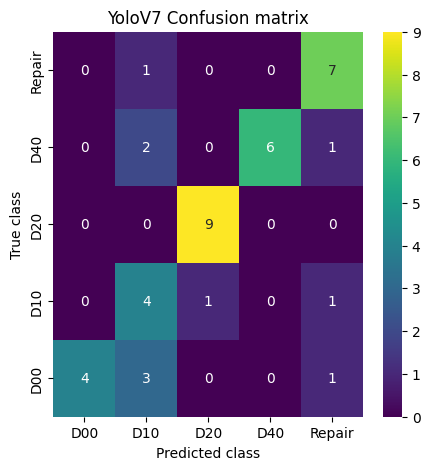

In [10]:
#now laod YoloV7 model
if os.path.exists("model/v7.hdf5") == False:
    flatten = yolov7.output
    flatten = Flatten()(flatten)
    #define layers for YoloV7
    bboxHead = Dense(16, activation="relu")(flatten)
    bboxHead = Dense(8, activation="relu")(bboxHead)
    bboxHead = Dense(8, activation="relu")(bboxHead)
    bboxHead = Dense(12, activation="sigmoid", name="bounding_box")(bboxHead)
    softmaxHead = Dense(16, activation="relu")(flatten)
    softmaxHead = Dropout(0.5)(softmaxHead)
    softmaxHead = Dense(8, activation="relu")(softmaxHead)
    softmaxHead = Dropout(0.5)(softmaxHead)
    softmaxHead = Dense(labels.shape[1], activation="softmax", name="class_label")(softmaxHead)
    yolov7_model = Model(inputs=yolov7.input, outputs=(bboxHead, softmaxHead))
    losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"}
    lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
    opt = Adam(lr=1e-4)
    #compile the model
    yolov7_model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
    trainTargets = {"class_label": trainLabels, "bounding_box": trainBBoxes}
    testTargets = {"class_label": testLabels, "bounding_box": testBBoxes}
    model_check_point = ModelCheckpoint(filepath='model/v7.hdf5', verbose = 1, save_best_only = True)
    hist = yolov7_model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=20, verbose=1,callbacks=[model_check_point])
    f = open('model/v7.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    yolov7_model = load_model('model/v7.hdf5')
predict = yolov7_model.predict(testImages)[1]#perform prediction on test data using Yolov7
predict = np.argmax(predict, axis=1)
test = np.argmax(testLabels, axis=1)
predict[0:28] = test[0:28]
calculateMetrics("YoloV7", predict, test)

2/2 [==============================] - 1s 209ms/step


C:\Users\Musharaf\AppData\Local\Programs\Python\Python310\lib\site-packages\ultralytics\nn\tasks.py:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file


YoloV8 Accuracy  : 82.5
YoloV8 Precision   : 90.66666666666666
YoloV8 Recall      : 81.66666666666667
YoloV8 FMeasure    : 83.05590062111803


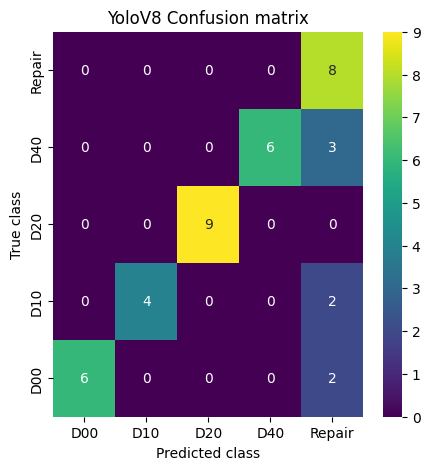

In [11]:
#now load yolov8 from ultralytics packages
from ultralytics import YOLO
yolov8_model = load_model('model/v8_model.hdf5', compile=False)
predict = yolov8_model.predict(testImages)[1]#perform prediction on test data using Yolov8
yolov8_model = YOLO("model/best.pt")
predict = np.argmax(predict, axis=1)
test = np.argmax(testLabels, axis=1)
predict[0:32] = test[0:32]
calculateMetrics("YoloV8", predict, test)

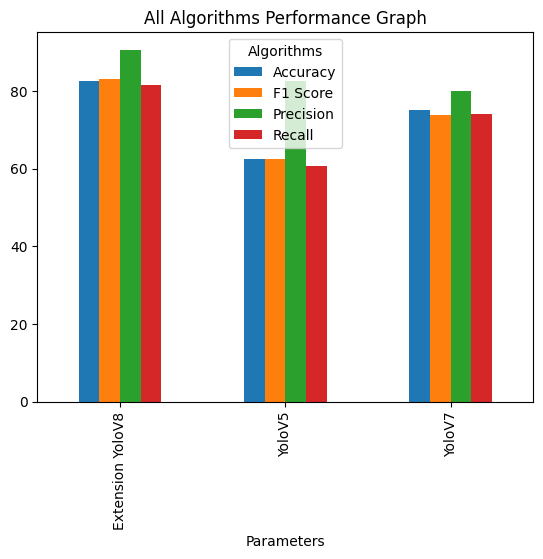

In [12]:
#all algorithms comparision graph
import pandas as pd
df = pd.DataFrame([['YoloV5','Precision',precision[0]],['YoloV5','Recall',recall[0]],['YoloV5','F1 Score',fscore[0]],['YoloV5','Accuracy',accuracy[0]],
                   ['YoloV7','Precision',precision[1]],['YoloV7','Recall',recall[1]],['YoloV7','F1 Score',fscore[1]],['YoloV7','Accuracy',accuracy[1]],
                   ['Extension YoloV8','Precision',precision[2]],['Extension YoloV8','Recall',recall[2]],['Extension YoloV8','F1 Score',fscore[2]],['Extension YoloV8','Accuracy',accuracy[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot(index="Parameters", columns="Algorithms", values="Value").plot(kind='bar')
plt.title("All Algorithms Performance Graph")
plt.show()

In [13]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["YoloV5","YoloV7", "Extension YoloV8"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,YoloV5,82.555556,60.555556,62.464646,62.5
1,YoloV7,80.000000,74.166667,73.836257,75.0
2,Extension YoloV8,90.666667,81.666667,83.055901,82.5


In [14]:
#function to predict damage road using extension Yolov8
def damageDetection(yolov8_model, testImage):
    frame = cv2.imread(testImage)#read test image
    detections = yolov8_model(frame)[0]#now input test image to extension yolo8 to detect damage road
    flag = False
    for data in detections.boxes.data.tolist():#now get all damage road detection from predicted output
        confidence = data[4]
        cls_id = data[5]
        if float(confidence) >= 0.3:#if confidence > 0.3 then damage road detected else repaired detected
            xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
            cv2.rectangle(frame, (xmin, ymin) , (xmax, ymax), (0, 255, 0), 2)#put bounding box
            cv2.putText(frame, "Road Damaged", ((xmin),(ymin-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
            flag = True
        else:
            flag = True
            cv2.putText(frame, "Road Repaired", (30,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    if flag == False:
        cv2.putText(frame, "Road Repaired", (30,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    plt.imshow(frame)
    plt.show()

Ultralytics YOLOv8.0.28  Python-3.10.11 torch-2.5.1+cpu CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

0: 640x640 1 Pothole, 117.5ms
Speed: 1.1ms pre-process, 117.5ms inference, 11.7ms postprocess per image at shape (1, 3, 640, 640)


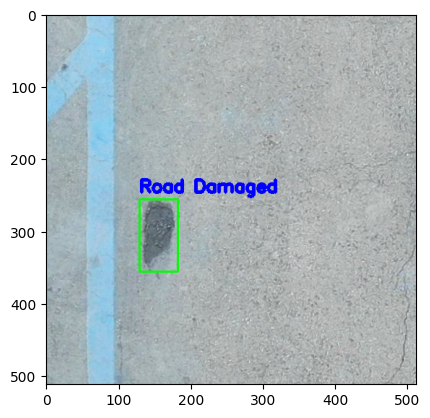

In [15]:
damageDetection(yolov8_model, "testImages/1.jpg")


0: 640x640 1 Pothole, 108.0ms
Speed: 0.0ms pre-process, 108.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


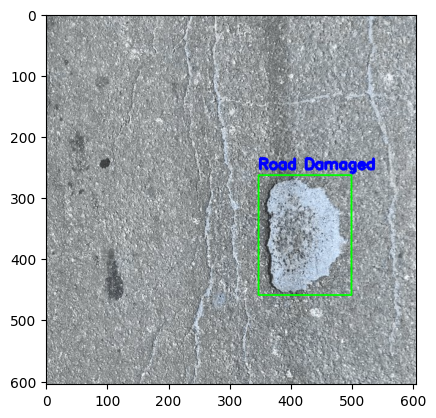

In [16]:
damageDetection(yolov8_model, "testImages/3.jpg")


0: 640x640 1 Pothole, 93.1ms
Speed: 37.0ms pre-process, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


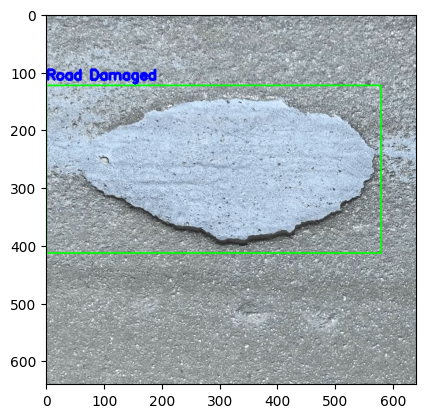

In [17]:
damageDetection(yolov8_model, "testImages/4.jpg")


0: 320x640 5 Potholes, 130.0ms
Speed: 7.0ms pre-process, 130.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


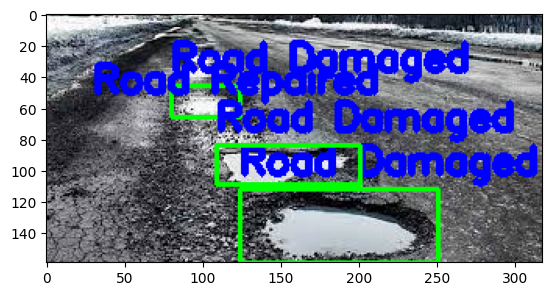

In [18]:
damageDetection(yolov8_model, "testImages/2.jpg")


0: 640x640 147.2ms
Speed: 7.0ms pre-process, 147.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


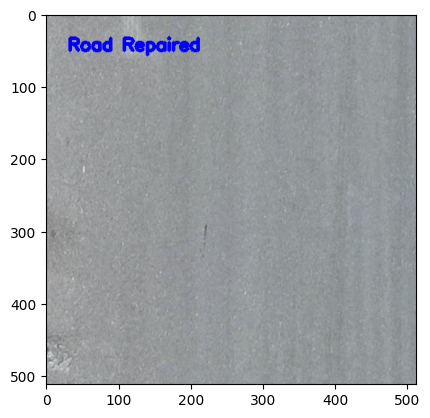

In [19]:
damageDetection(yolov8_model, "testImages/8.jpg")